In [141]:
import os
import pandas as pd
import numpy as np
import re
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import SnowballStemmer
from bs4 import BeautifulSoup
import string

In [164]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk.translate.gleu_score as gleu
from nltk.translate.meteor_score import meteor_score
from nltk.translate.nist_score import sentence_nist, corpus_nist
from nltk.tokenize import word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
from nltk import RegexpTokenizer

In [31]:
import spacy

In [32]:
from glob import glob

In [81]:
#os.getcwd()

In [14]:
list_of_names = ['cs_en', 'de_en', 'en_fi', 'en_zh', 'ru_en', 'zh_en', 'en_fi', 'en_zh']

In [345]:
cs_en = pd.read_csv("corpus/cs-en/scores.csv")
de_en = pd.read_csv("corpus/de-en/scores.csv")
en_fi = pd.read_csv("corpus/en-fi/scores.csv")
en_zh = pd.read_csv("corpus/en-zh/scores.csv")
ru_en = pd.read_csv("corpus/ru-en/scores.csv")
zh_en = pd.read_csv("corpus/zh-en/scores.csv")

data_to_eng = [cs_en, de_en, ru_en, zh_en]
data_from_eng = [en_fi, en_zh]

In [257]:
cs_en = pd.DataFrame(data=cs_en,columns=['reference','translation','z-score'])
de_en = pd.DataFrame(data=de_en,columns=['reference','translation','z-score'])
en_fi = pd.DataFrame(data=en_fi,columns=['reference','translation','z-score'])
en_zh = pd.DataFrame(data=en_zh,columns=['reference','translation','z-score'])
ru_en = pd.DataFrame(data=ru_en,columns=['reference','translation','z-score'])
zh_en = pd.DataFrame(data=zh_en,columns=['reference','translation','z-score'])

In [362]:
def load_dataset():
    # dataframes provided with the corresponding language translations

    # assign dataset names
    list_of_names = ['cs-en', 'de-en', 'ru-en', 'zh-en', 'en-fi', 'en-zh']

    # create empty list
    dataframes_list = []
  
    # append datasets into teh list
    for i in range(len(list_of_names)):

        temp_df = pd.read_csv("corpus/"+ list_of_names[i]+"/scores.csv")

        dataframes_list.append(temp_df)

    return dataframes_list

In [363]:
dataframes_list = load_dataset()

In [364]:
def new_func(df):
    df = df.replace(r'^\s*$', np.NaN, regex=True)
    df = df.dropna()
    return df

In [366]:
cs_en.shape

(11578, 8)

In [367]:
de_en.shape

(21704, 6)

In [369]:
cs_en.head()

,source,reference,translation,z-score,avg-score,annotators,word_count_ref,word_count_tra
0,Uchopíte pak zbraň mezi své předloktí a rameno...,You will then grab the weapon between your for...,You then grasp the gun between your forearm an...,-0.675383,60.000000,3,23,20
1,"Ale je-li New York změna, pak je to také znovu...","But if New York is changed, then it's also a r...","But if New York is change, it is also reinvent...",-0.829403,44.000000,2,11,10
2,"Dlouho a intenzivně jsem během léta přemýšlel,...",I have been thinking over and over again over ...,I have thought long and hard over the course o...,0.803185,96.500000,2,29,33
3,"Najdou si jiný způsob, jak někde podvádět.",They find another way to cheat somewhere.,They will find another way how to defraud others.,0.563149,90.500000,2,7,9
4,Zpráva o výměně v čele prezidentovy administra...,The report on the replacement of the president...,The news of the replacement at the top of the ...,0.021549,74.666667,3,20,26


## Preprocessing

In [372]:
stop_en = set(stopwords.words('english'))
stop_fi = set(stopwords.words('finnish'))
# stop_zh = chinese library needed 
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
snowball_stemmer = SnowballStemmer('english')

def clean_data(text_list, lemmatize=False, stemmer=False, punctuation = False, stop_words=False, stop = stop_en):
    """
    Function that a receives a list of strings and preprocesses it.
    
    :param text_list: List of strings.
    :param lemmatize: Tag to apply lemmatization if True.
    :param stemmer: Tag to apply the stemmer if True.
    """
    updates = []
    for j in tqdm(range(len(text_list))):
        
        text = text_list[j]
        
        #LOWERCASE TEXT
        text = text.lower()
        
        #REMOVE NUMERICAL DATA AND PUNCTUATION
        if punctuation:
            text = re.sub("[^a-zA-Z]", ' ', text)
        
        #REMOVE TAGS (HTML)
        text = BeautifulSoup(text).get_text()
        
        #REMOVE STOP WORDS - not needed 
        if stop_words:
            text = " ".join([word for word in text.split() if word not in stop])
        
        #LEMMATIZATION
        if lemmatize:
            text = " ".join(lemma.lemmatize(word) for word in text.split())
        
        #STEMMER
        if stemmer:
            text = " ".join(snowball_stemmer.stem(word) for word in text.split())
        
        updates.append(text)
        
    return updates

def update_df(dataframe, list_updated, column):
    dataframe.update(pd.DataFrame({column: list_updated}))
    
#updates = clean(df["translation"], lemmatize = False, stemmer = False)
#update_df(df, updates, "translation")

def number_token(text):
    """
    Function that receives a string of text and returns the string with 
    the cost formats within it substituted by the token #COST
    """
    tokenized_text = re.sub('(\d+|\d+.\d+)(| )','##',text)
        
    return tokenized_text

def total_word_freq(text_list):
    """
    Function that receives a list of strings and returns the frequency of each word
    in the set of all strings.
    """
    words_in_df = ' '.join(text_list).split()
    # Count all words 
    freq = pd.Series(words_in_df).value_counts()
    return freq

# Fetch wordcount for each abstract
def word_count(df):
    word_count_ref  = df['reference'].apply(lambda x: len(str(x).split(" ")))
    word_count_tra  = df['translation'].apply(lambda x: len(str(x).split(" ")))
    df['word_count_ref'] = word_count_ref
    df['word_count_tra'] = word_count_tra

In [381]:
def number_token(df):

    def transform_number(text):
        """
        Function that receives a string of text and returns the string with 
        the cost formats within it substituted by the token #COST
        """
        tokenized_text = re.sub('(\d+|\d+.\d+)(| )','##',text)
            
        return tokenized_text

    df["reference"] = [transform_number(x) for x in df["reference"]]
    df["translation"] = [transform_number(x) for x in df["translation"]]

def tokenize(df):
    df['reference_token'] = [[x.split()] for x in df['reference']]
    df['translation_token'] = [x.split() for x in df['translation']]
    return df

In [382]:
for df in dataframes_list:
    word_count(df)
    new_func(df)
    
    #for df in data_to_eng:
    updates = clean(df["reference"], lemmatize = False, stemmer = False, stop_words=False, stop = stop_en)
    update_df(df, updates, "reference")
    
    updates = clean(df["translation"], lemmatize = False, stemmer = False, stop_words=False, stop = stop_en)
    update_df(df, updates, "translation")
    
    number_token(df)
    df = tokenize(df)

TypeError: 'DataFrame' object is not callable

## Bag-of-words

In [80]:
# list of text documents
text = ["The quick brown fox jumped over the lazy dog."]
# create the transform
vectorizer = CountVectorizer()
# tokenize and build vocab
vectorizer.fit(text)
# summarize
print(vectorizer.vocabulary_)
# encode document
vector = vectorizer.transform(text)
# summarize encoded vector
print(vector.shape)
print(type(vector))
print(vector.toarray())

#all words were made lowercase by default and that the punctuation was ignored.

{'the': 7, 'quick': 6, 'brown': 0, 'fox': 2, 'jumped': 3, 'over': 5, 'lazy': 4, 'dog': 1}
(1, 8)
<class 'scipy.sparse.csr.csr_matrix'>
[[1 1 1 1 1 1 1 2]]


In [97]:
cv = CountVectorizer(max_df=0.9, binary=True)

In [99]:
X = cv.fit_transform(cs_en["reference"])

In [101]:
list(cv.vocabulary_.keys())[:10]

['you',
 'will',
 'then',
 'grab',
 'the',
 'weapon',
 'between',
 'your',
 'forearm',
 'and']

In [102]:
def get_top_n_grams(corpus, top_k, n):
    """
    Function that receives a list of documents (corpus) and extracts
        the top k most frequent n-grams for that corpus.
        
    :param corpus: list of texts
    :param top_k: int with the number of n-grams that we want to extract
    :param n: n gram type to be considered 
             (if n=1 extracts unigrams, if n=2 extracts bigrams, ...)
             
    :return: Returns a sorted dataframe in which the first column 
        contains the extracted ngrams and the second column contains
        the respective counts
    """
    vec = CountVectorizer(ngram_range=(n, n), max_features=2000).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0) 
    
    words_freq = []
    for word, idx in vec.vocabulary_.items():
        words_freq.append((word, sum_words[0, idx]))
        
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    top_df = pd.DataFrame(words_freq[:top_k])
    top_df.columns = ["Ngram", "Freq"]
    return top_df

In [103]:
top_df = get_top_n_grams(cs_en["reference"], top_k=20, n=1)

In [104]:
top_df.head(10)

,Ngram,Freq
0,the,16608
1,of,6705
2,and,5597
3,to,5516
4,in,5384
5,that,2590
6,is,2348
7,for,2230
8,it,2146
9,on,1883


In [105]:
def plot_frequencies(top_df):
    """
    Function that receives a dataframe from the "get_top_n_grams" function
    and plots the frequencies in a bar plot.
    """
    x_labels = top_df["Ngram"][:30]
    y_pos = np.arange(len(x_labels))
    values = top_df["Freq"][:30]
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, x_labels)
    plt.ylabel('Frequencies')
    plt.title('Words')
    plt.xticks(rotation=90)
    plt.show()

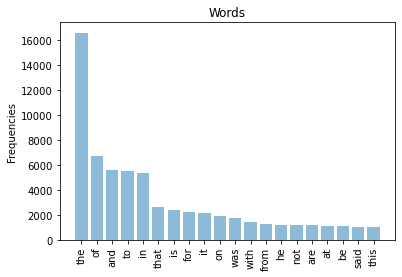

In [106]:
plot_frequencies(top_df)

In [110]:
tfidf_vectorizer = TfidfTransformer()
tfidf_vectorizer.fit(X)

TfidfTransformer()

In [111]:
# get feature names
feature_names = cv.get_feature_names()
 
# fetch document for which keywords needs to be extracted
doc = cs_en["reference"][53]
 
#generate tf-idf for the given document
tf_idf_vector = tfidf_vectorizer.transform(cv.transform([doc]))

In [112]:
tf_idf_vector.toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [113]:
def extract_feature_scores(feature_names, document_vector):
    """
    Function that creates a dictionary with the TF-IDF score for each feature.
    :param feature_names: list with all the feature words.
    :param document_vector: vector containing the extracted features for a specific document
    
    :return: returns a sorted dictionary "feature":"score".
    """
    feature2score = {}
    for i in range(len(feature_names)):
        feature2score[feature_names[i]] = document_vector[0][i]    
    return sorted(feature2score.items(), key=lambda kv: kv[1], reverse=True)

In [114]:
extract_feature_scores(feature_names, tf_idf_vector.toarray())[:10]

[('ivanova', 0.45965803231546404),
 ('indicated', 0.41419029168137467),
 ('request', 0.39780288615923837),
 ('dismissed', 0.3875504703819323),
 ('own', 0.30762199456396994),
 ('putin', 0.30118473173155647),
 ('his', 0.20848814538858373),
 ('at', 0.1845892512861643),
 ('was', 0.16164018002688982),
 ('that', 0.14038095259004488)]

## Models

In [373]:
# baseline bleu
from nltk.translate.bleu_score import sentence_bleu
#print('Cumulative 1-gram: %f' % sentence_bleu(reference, candidate, weights=(1, 0, 0, 0)))
#print('Cumulative 2-gram: %f' % sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)))
#print('Cumulative 3-gram: %f' % sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0)))
from rouge import Rouge
from nltk.translate.nist_score import sentence_nist
from nltk.translate.chrf_score import sentence_chrf
from sklearn import preprocessing
# check pytorch version
import torch
print(torch.__version__)

1.8.1+cpu


In [377]:
# measures precision
def baseline_bleu(df):
    smoothie = SmoothingFunction().method1
    df['bleu'] = df.apply(lambda x: sentence_bleu(x['reference_token'], x['translation_token'], weights=(1,0,0,0), smoothing_function=smoothie), axis=1)
    return df 

def sacre_bleu(df):
    df['sacre_bleu'] = df.apply(lambda x: sacrebleu.corpus_bleu(x['reference'], x['translation']).score, axis=1)
    return df 

def nist(df):
    # tokenization happens inside nist
    df['nist'] = df.apply(lambda x: corpus_nist(x['reference'], x['translation']),axis=1)
    return df 

# measures recall
def rouge_1(df):
    rouge = Rouge()
    df['rouge'] = df.apply(lambda x: rouge.get_scores(x['translation'], x['reference'], avg=True)['rouge-1']['f'],axis=1) 
    return df

def bleu_rouge(df):
    df['bleu_rouge'] = 2 * (df['bleu'] * df['rouge']) / (df['bleu'] + df['rouge'])
    df['bleu_rouge'] = df['bleu_rouge'].replace(np.nan, 0)
    return df

def meteor(df):
    df['meteor'] = df.apply(lambda x: meteor_score([x['reference']], x['translation']),axis=1)
    #If no words match during the method returns the score of 0
    return df

def charf(df):
    df['charf'] = df.apply(lambda x: sentence_chrf([x['reference']], x['translation']),axis=1)
    return df

import sacrebleu
def sacre_bleu(df):
    df['sacre_bleu'] = df.apply(lambda x: sacrebleu.corpus_bleu(x['reference'], x['translation']).score, axis=1)
    
    x = clean['sacre_bleu'].values.reshape(-1, 1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    clean['sacre_bleu'] = pd.DataFrame(x_scaled)
    
    return df 

def charf(df):
    df['charf'] = df.apply(lambda x: sentence_chrf([x['reference']], x['translation']),axis=1)
    return df

In [374]:
clean_cs = cs_en.copy()

In [380]:
for df in dataframes_list[:-2]:
    meteor(df)
    baseline_bleu(df)
    rouge_1(df)
    bleu_rouge(df)
    sacre_bleu(df)
    charf(df)

KeyError: 'reference_token'

In [379]:
#sentence_nist(cs_en['reference'][12],cs_en['translation'][12])

In [ ]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())

In [ ]:
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

In [148]:
ref_embedding = np.load('corpus/de-en/laser.reference_embeds.npy')

In [149]:
source_embedding = np.load('corpus/de-en/laser.source_embeds.npy')

In [156]:
type(ref_embedding)

numpy.ndarray

In [162]:
type(tf.convert_to_tensor(ref_embedding, dtype=tf.float32))

tensorflow.python.framework.ops.EagerTensor

In [155]:
import torch.nn.functional as F
import tensorflow as tf


def similarity(embeddings_1, embeddings_2):
    embeddings_1 = tf.convert_to_tensor(embeddings_1, np.float32)
    embeddings_2 = tf.convert_to_tensor(embeddings_2.transpose(0,1), np.float32)
    return torch.matmul(
        embeddings_1, embeddings_2
    )

print(similarity(ref_embedding, source_embedding))

TypeError: matmul(): argument 'input' (position 1) must be Tensor, not tensorflow.python.framework.ops.EagerTensor

## Evaluate

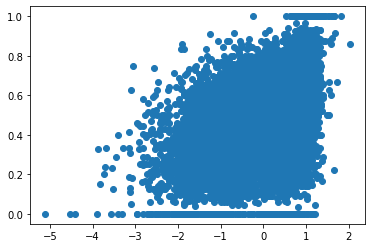

In [216]:
from matplotlib import pyplot
pyplot.scatter(clean_csen['z-score'], clean_csen['bleu'])
pyplot.show()

In [245]:
from scipy.stats import kendalltau
from scipy.stats import pearsonr
kendalltau(clean_enzh['z-score'], clean_enzh['bleu'])

KendalltauResult(correlation=0.006092200466591761, pvalue=0.4496644917384327)

In [244]:
pearsonr(clean_enzh['z-score'], clean_enzh['bleu'])

(0.027343797324263654, 0.005699118713376936)

In [219]:
kendalltau(clean_csen['z-score'], clean_csen['meteor'])

KendalltauResult(correlation=0.26861300731477705, pvalue=0.0)

In [221]:
pearsonr(clean_csen['z-score'], clean_csen['meteor'])

(0.3957474789630241, 0.0)